In [1]:
cd ..

/home/rd804/m-anode


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys


In [3]:


parser = argparse.ArgumentParser()
parser.add_argument('--n_sig',type=int , default=750, help='signal train')
parser.add_argument('--mode_background', type=str, default='freeze', help='train, freeze, pretrained')


parser.add_argument('--epochs', type=int, default=2, help='epochs')
parser.add_argument('--batch_size', type=int, default = 256, help = 'batch size')
parser.add_argument('--mini_batch', type=int, default=256, help='mini batch size')
parser.add_argument('--gpu', type=str, default='cuda:0', help='gpu to train on')
parser.add_argument('--data_loss_expr', type=str, default='true_likelihood', help='loss for SR region')


parser.add_argument('--resample', action='store_true', help='if data is to resampled')
parser.add_argument('--seed', type=int, default=11, help='seed')
parser.add_argument('--shuffle_split', action='store_true', help='if shuffle split is used')
parser.add_argument('--split', type=int, default=1, help='split number')
parser.add_argument('--data_dir', type=str, default='data/lhc_co', help='data directory')
parser.add_argument('--config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')
parser.add_argument('--S_config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')

parser.add_argument('--CR_path', type=str, default='results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0', help='CR data path')
parser.add_argument('--ensemble', action='store_true',default = True ,help='if ensemble is used')

parser.add_argument('--wandb', action='store_true', help='if wandb is used' )
parser.add_argument('--wandb_group', type=str, default='debugging_r_anode')
parser.add_argument('--wandb_job_type', type=str, default='lhc_co')
parser.add_argument('--wandb_run_name', type=str, default='try_10')





_StoreAction(option_strings=['--wandb_run_name'], dest='wandb_run_name', nargs=None, const=None, default='try_10', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [4]:
args = parser.parse_args(args=[])

In [5]:



if not os.path.exists(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}'):
    os.makedirs(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}')


if args.wandb:
    wandb.init(project="r_anode", config=args,
                group=args.wandb_group, job_type=args.wandb_job_type)

    wandb.run.name = args.wandb_run_name

# print wandb group


CUDA = True
device = torch.device(args.gpu if CUDA else "cpu")

SR_data, CR_data , true_w, sigma = resample_split(args.data_dir, n_sig = args.n_sig, resample_seed = args.seed,resample = args.resample)

print('x_train shape', SR_data.shape)
print('true_w', true_w)
print('sigma', sigma)

if args.wandb:
    wandb.config.update({'true_w': true_w, 'sigma': sigma})




using first 750 signal events for mock_data from 70000 events
sigma=1.6907983900300265
true w: 0.004830204771159823
x_train shape (121941, 6)
true_w 0.004830204771159823
sigma 1.6907983900300265


In [6]:
pre_parameters_SR = preprocess_params_fit(SR_data)
# save pre_parameters of SR
with open(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/pre_parameters.pkl','wb') as f:
    pickle.dump(pre_parameters_SR, f)


# load pre_parameters of CR 
with open(f'{args.CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters_CR = pickle.load(f)

pre_parameters_SR = pre_parameters_CR


In [7]:

_, mask_CR = logit_transform(SR_data[:,1:-1], pre_parameters_CR['min'],
                             pre_parameters_CR['max'])
_, mask_SR = logit_transform(SR_data[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])

mask = mask_CR & mask_SR

x_train = SR_data[mask]

# have two seperate transforms of the data for model_S and model_B
x_train_S = preprocess_params_transform(x_train, pre_parameters_CR) 
#x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)
x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)


In [8]:


# create masked test data
_x_test = np.load(f'{args.data_dir}/x_test.npy')
_, mask_CR = logit_transform(_x_test[:,1:-1], pre_parameters_CR['min'],
                                pre_parameters_CR['max'])
_, mask_SR = logit_transform(_x_test[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])
mask_test = mask_CR & mask_SR
x_test = _x_test[mask_test]

x_test_CR = preprocess_params_transform(x_test, pre_parameters_CR)
#x_test_SR = preprocess_params_transform(x_test, pre_parameters_SR)
x_test_SR = preprocess_params_transform(x_test, pre_parameters_CR)



In [9]:

if not args.shuffle_split:    
    data_train_S, data_val_S = train_test_split(x_train_S, test_size=0.5, random_state=args.seed)
    data_train_B, data_val_B = train_test_split(x_train_B, test_size=0.5, random_state=args.seed)

else:
    ss_data = ShuffleSplit(n_splits=20, test_size=0.5, random_state=22)

    print(f'doing a shuffle split with split number {args.split}')

    for i, (train_index, test_index) in enumerate(ss_data.split(x_train)):
        if i == args.split:
            data_train_S, data_val_S = x_train_S[train_index], x_train_S[test_index]
            data_train_B, data_val_B = x_train_B[train_index], x_train_B[test_index]
            break

#data_train_B = x_train_B
#data_val_B = x_train_B

#data_train_S = x_train_S
#data_val_S = x_train_S

#x_test = preprocess_params_transform(_x_test, pre_parameters)


traintensor_S = torch.from_numpy(data_train_S.astype('float32')).to(device)
traintensor_B = torch.from_numpy(data_train_B.astype('float32')).to(device)

valtensor_S = torch.from_numpy(data_val_S.astype('float32')).to(device)
valtensor_B = torch.from_numpy(data_val_B.astype('float32')).to(device)
#testtensor = torch.from_numpy(x_test.astype('float32')).to(device)

testtensor_S = torch.from_numpy(x_test_SR.astype('float32')).to(device)
testtensor_B = torch.from_numpy(x_test_CR.astype('float32')).to(device)

print('X_train shape', traintensor_S.shape)
print('X_train shape', traintensor_B.shape)

print('X_val shape', valtensor_S.shape)
print('X_val shape', valtensor_B.shape)

print('X_test shape', testtensor_S.shape)
print('X_test shape', testtensor_B.shape)

pre_parameters_S_tensor = pre_parameters_SR.copy()
pre_parameters_B_tensor = pre_parameters_CR.copy()

for key in pre_parameters_S_tensor.keys():
    pre_parameters_S_tensor[key] = torch.from_numpy(pre_parameters_S_tensor[key].astype('float32')).to(device)

for key in pre_parameters_B_tensor.keys():
    pre_parameters_B_tensor[key] = torch.from_numpy(pre_parameters_B_tensor[key].astype('float32')).to(device)


train_tensor = torch.utils.data.TensorDataset(traintensor_S, traintensor_B)
val_tensor = torch.utils.data.TensorDataset(valtensor_S, valtensor_B)

#test_tensor = torch.utils.data.TensorDataset(testtensor)


# Use the standard pytorch DataLoader
batch_size = args.batch_size
trainloader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(val_tensor, batch_size=test_batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test_tensor, batch_size=test_batch_size, shuffle=False)



#model_S = DensityEstimator(args.S_config_file, eval_mode=False, device=device)



X_train shape torch.Size([60964, 6])
X_train shape torch.Size([60964, 6])
X_val shape torch.Size([60964, 6])
X_val shape torch.Size([60964, 6])
X_test shape torch.Size([366150, 6])
X_test shape torch.Size([366150, 6])


In [10]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal, StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation, RandomPermutation
# import bactchnorm
from nflows.transforms.normalization import BatchNorm
from nflows.nn.nets import ResidualNet
from nflows.transforms.made import MADE

In [11]:


num_layers = 8
base_dist = StandardNormal(shape=[4])

transforms = []
for _ in range(num_layers):
    transforms.append(MaskedAffineAutoregressiveTransform(features=4, hidden_features=64, use_residual_blocks=False,
                                                          context_features=1, random_mask=True,
                                                          num_blocks=2, use_batch_norm=True,
                                                          activation=F.leaky_relu, dropout_probability=0.2))
    transforms.append(BatchNorm(features=4))
    transforms.append(RandomPermutation(features=4))

transform = CompositeTransform(transforms)

model_S = Flow(transform, base_dist).to(device)



In [12]:
model_S

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=True)
          (context_layer): Linear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (batch_norm): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=8, bias=True)
        )
      )
      (1): BatchNorm()
      (2): RandomPermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=True)
          (con

In [13]:
x = traintensor_S[:128,1:-1]
#y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
y = traintensor_S[:128,0].reshape(-1, 1).to(device)
print(x.shape)
print(y.shape)

loss = model_S.log_prob(x,y)
print(loss.shape)

torch.Size([128, 4])
torch.Size([128, 1])
torch.Size([128])


In [14]:
x.shape

torch.Size([128, 4])

In [15]:
y.shape

torch.Size([128, 1])

In [16]:
traintensor_S_1 = traintensor_S[0:100,1:-1]
traintensor_S_2 = traintensor_S[0:100,-1].reshape(-1,1)

print(traintensor_S_1.shape)
print(traintensor_S_2.shape)
model_S.log_prob(inputs=traintensor_S_1, context=traintensor_S_2)

torch.Size([100, 4])
torch.Size([100, 1])


tensor([ -4.6137,  -5.5356,  -5.6031,  -8.8270,  -4.1854,  -9.9147,  -9.9793,
         -4.7267,  -4.8175,  -5.1497,  -4.7801,  -3.6684,  -7.1406,  -6.7185,
         -4.7109,  -6.4550,  -6.3757,  -7.5531,  -4.5178,  -4.4833,  -3.4145,
         -7.9057,  -6.2856,  -5.4141,  -5.9282,  -6.3640,  -4.7195, -11.2189,
         -4.7890,  -5.5068,  -7.0878,  -6.4140,  -4.7100,  -6.2769,  -4.8418,
         -5.8493,  -5.2836,  -5.0375,  -4.5633,  -4.2268,  -3.8754,  -6.8424,
         -4.1809,  -4.8125, -22.9211,  -8.4163,  -7.0451,  -6.5412,  -4.0133,
         -5.4259,  -4.6617,  -5.5335,  -6.8269,  -5.4551,  -4.9598,  -4.8274,
         -5.0485,  -9.3034,  -6.8945,  -4.4983,  -5.8074,  -5.3711, -11.0593,
         -5.6815,  -7.4648,  -5.0201,  -5.1534,  -4.8105,  -4.3169,  -4.7464,
         -5.3901,  -7.2397,  -4.3941,  -5.1717,  -4.8946,  -4.7364,  -6.6259,
         -8.5521,  -7.2824,  -8.1493,  -8.6843,  -5.3632,  -4.7232,  -5.9843,
         -7.3808,  -6.4018,  -7.7931,  -4.3951,  -5.9915,  -4.20

In [17]:

if args.mode_background == 'train':
    pass

elif args.mode_background == 'freeze':
 #   val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    val_losses = np.load(f'{args.CR_path}/valloss_list.npy')
    best_epoch = np.argmin(val_losses)
    #model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)
    model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{best_epoch}.pt", device=device)

elif args.mode_background == 'pretrained':
    val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    best_epoch = np.argmin(val_losses)
    model_B = DensityEstimator(args.config_file, eval_mode=False, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)




valloss = []
trainloss = []



pre_parameters = {}

pre_parameters['CR'] = pre_parameters_B_tensor
pre_parameters['SR'] = pre_parameters_S_tensor


DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt


In [18]:
#train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
#val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()

train_data = inverse_transform(traintensor_S, pre_parameters['CR']).cpu().detach().numpy()
val_data = inverse_transform(valtensor_S, pre_parameters['CR']).cpu().detach().numpy()


all_data = np.vstack((train_data, val_data))




In [19]:
sum(p.numel() for p in model_S.parameters()
                               if p.requires_grad)

76416

In [20]:
# one cycle lr scheduler
epochs = 100
#optimizer = torch.optim.AdamW(model_S.model.parameters())
optimizer = torch.optim.AdamW(model_S.parameters())
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(trainloader), epochs=epochs, anneal_strategy='linear')

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  0 trainloss:  5.438955773868321 valloss:  5.427695999542872
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


/tmp/ipykernel_1251819/537126016.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/IndexingUtils.h:27.)
  x_samples = x_samples[~np.isnan(x_samples).any(axis=1)]


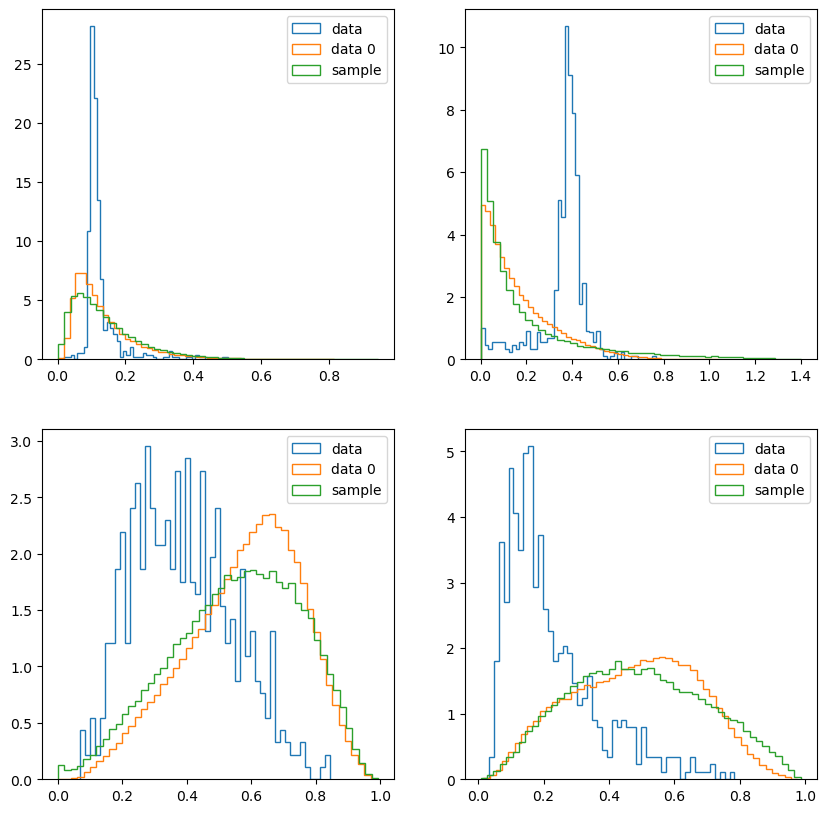

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  1 trainloss:  5.438152193524349 valloss:  5.427666326363881
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


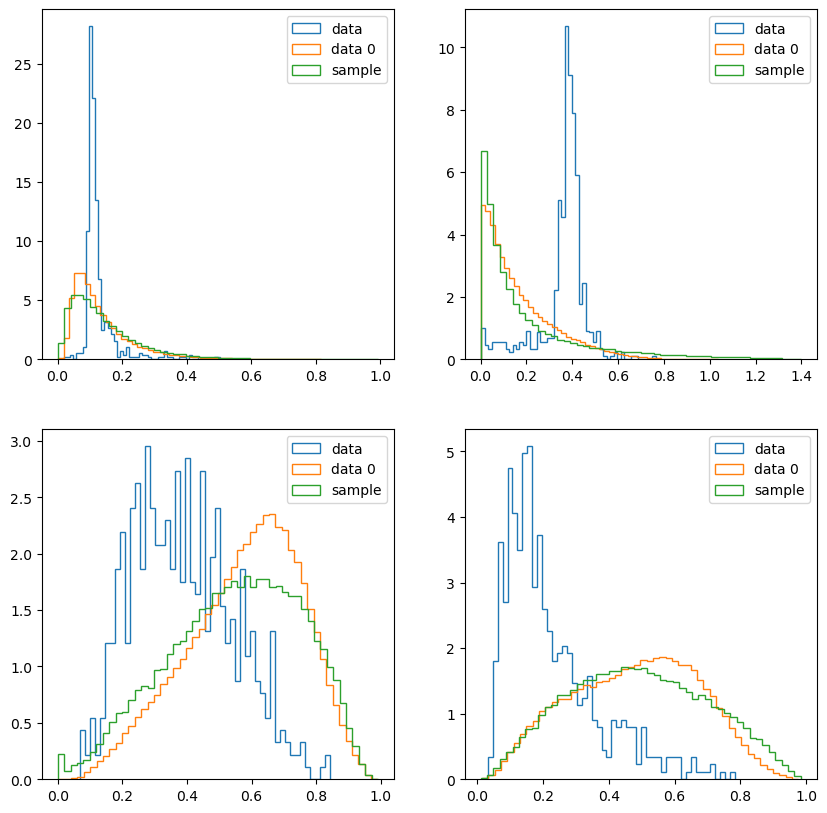

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  2 trainloss:  5.43825189039797 valloss:  5.427515357732773
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


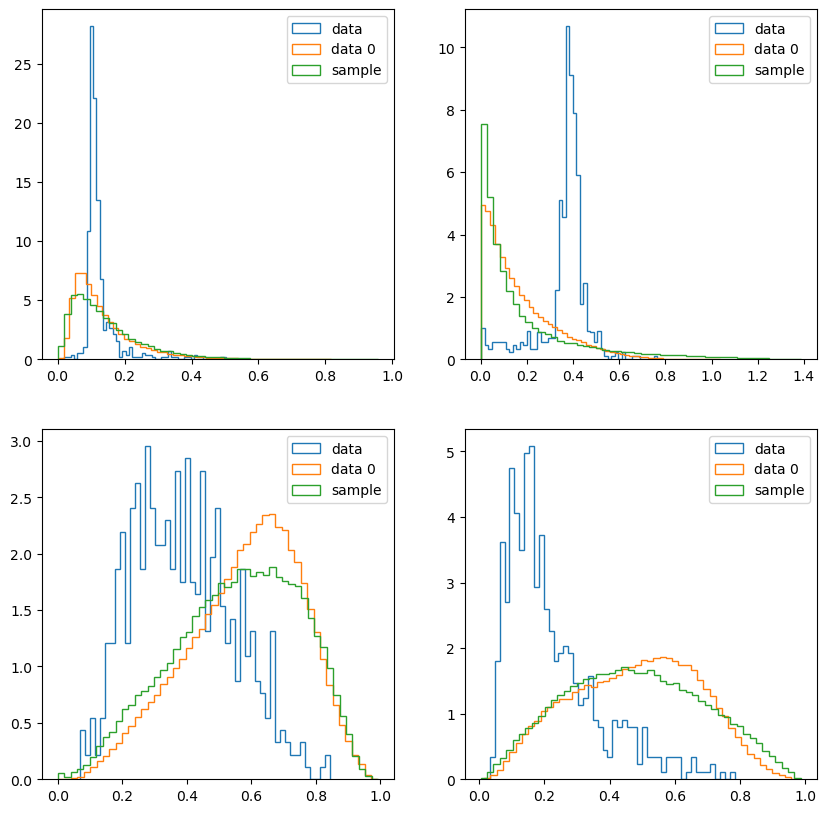

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  3 trainloss:  5.438422037467797 valloss:  5.4274797439575195
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


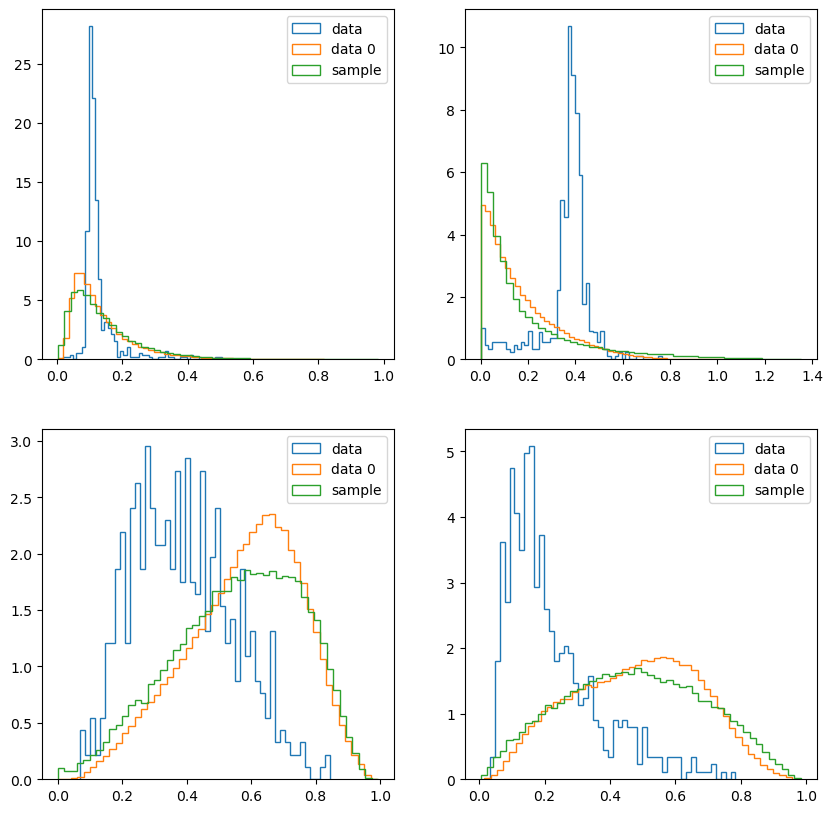

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  4 trainloss:  5.438022354157899 valloss:  5.427654663721721
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


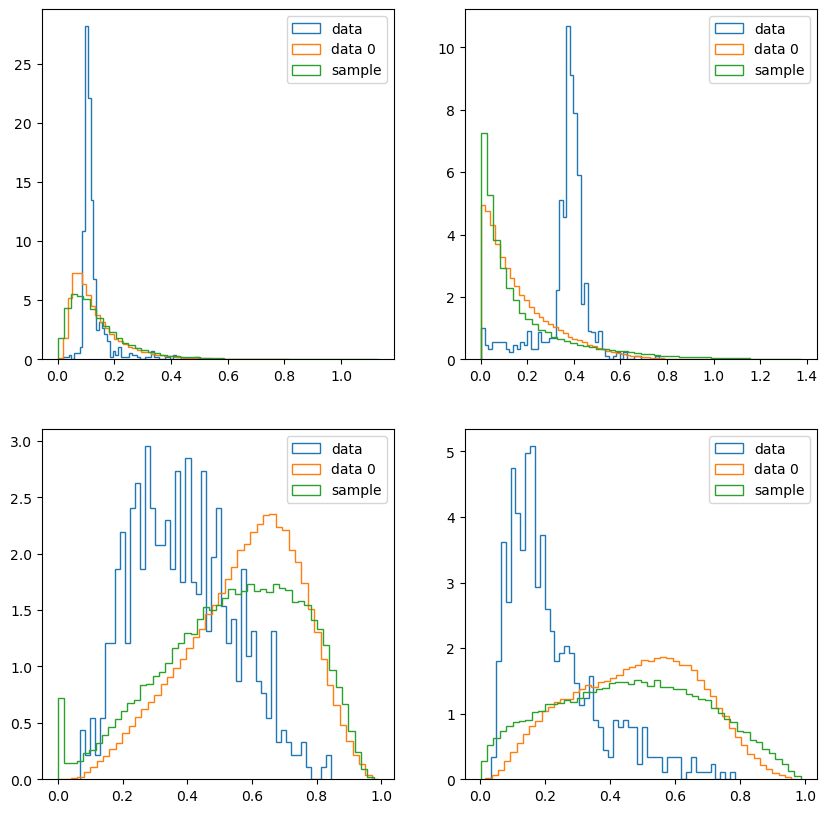

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  5 trainloss:  5.438249839399649 valloss:  5.42753466963768
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


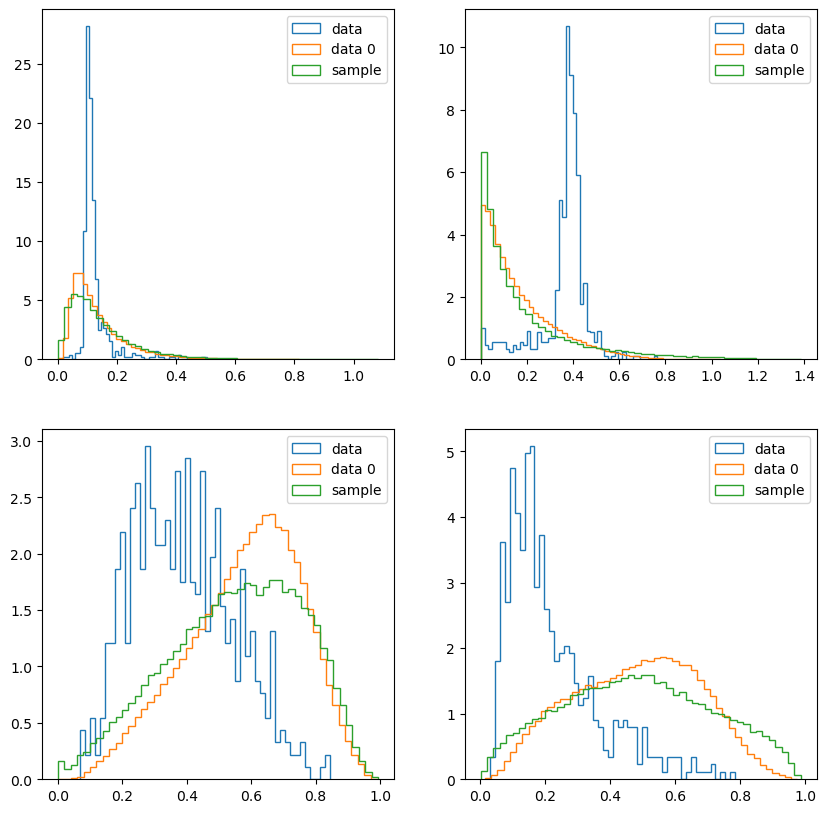

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  6 trainloss:  5.437895345887379 valloss:  5.427531450986862
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


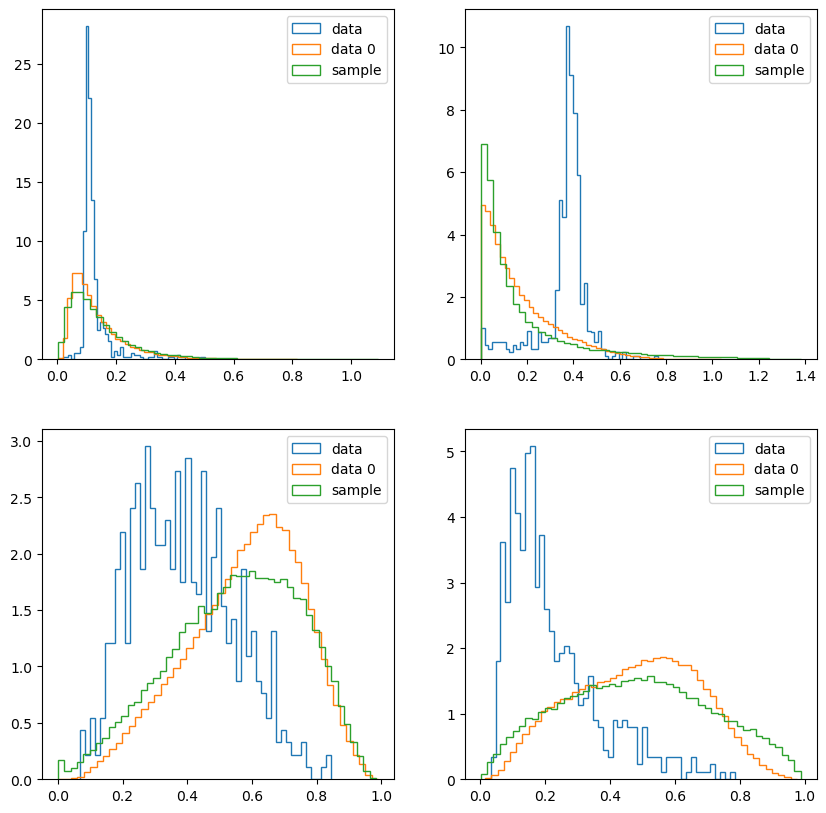

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  7 trainloss:  5.437706556280288 valloss:  5.427502294381459
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


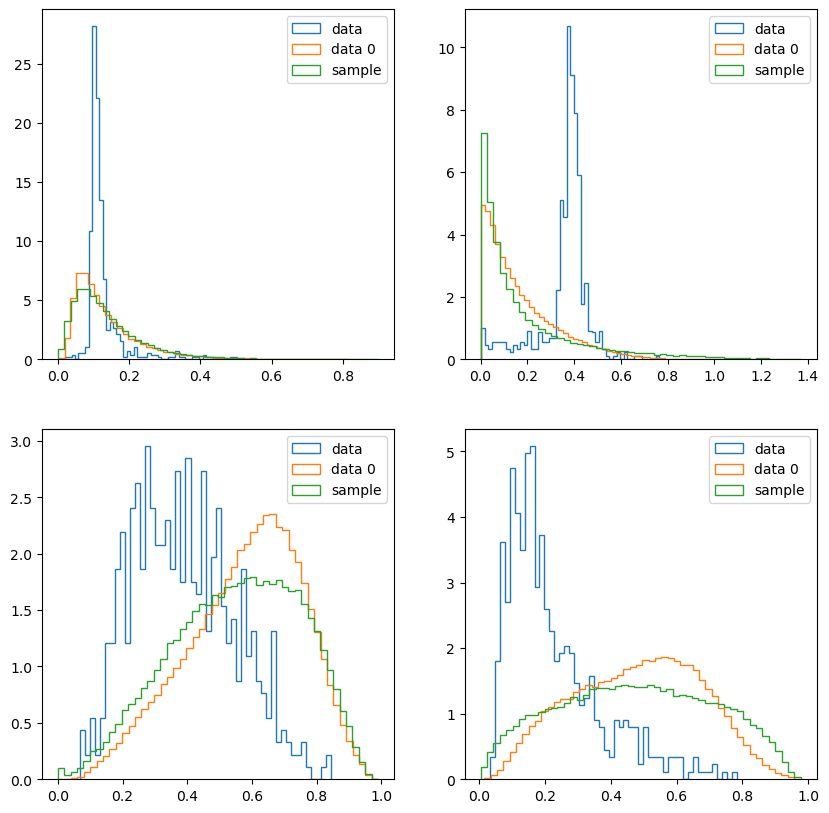

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  8 trainloss:  5.438419232308616 valloss:  5.427524129549663
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


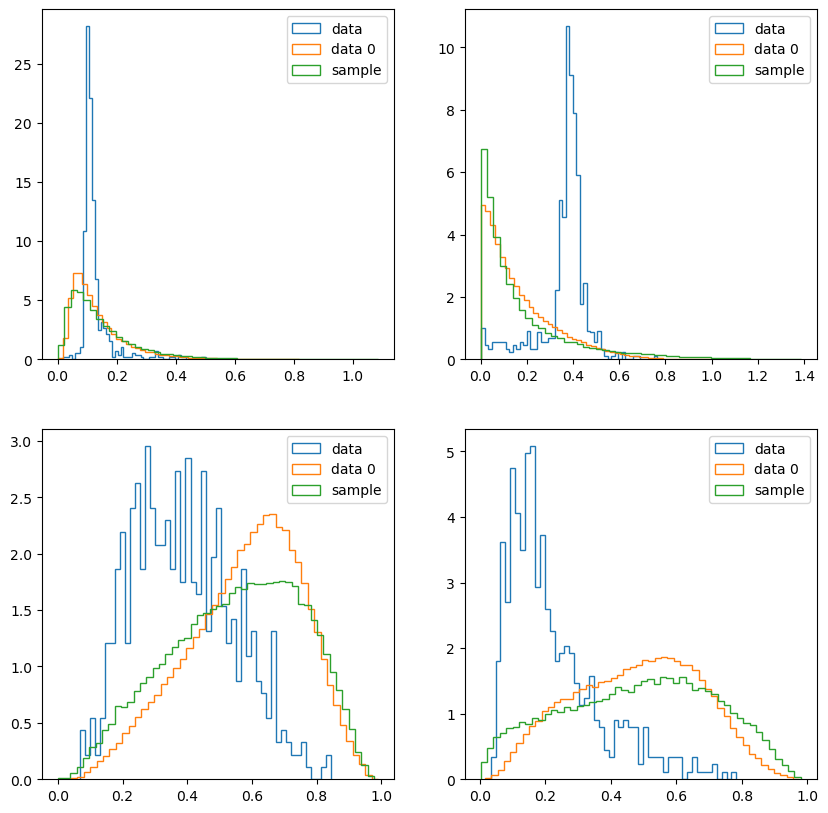

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  9 trainloss:  5.43904099205049 valloss:  5.427594582239787
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


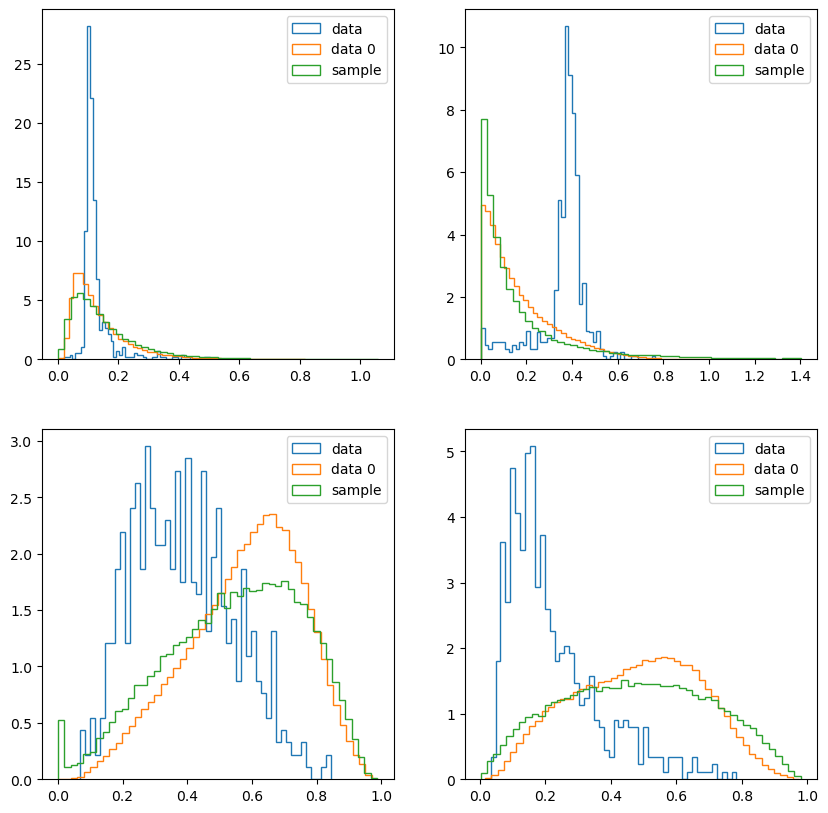

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  10 trainloss:  5.437787600640971 valloss:  5.4275639454523725
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


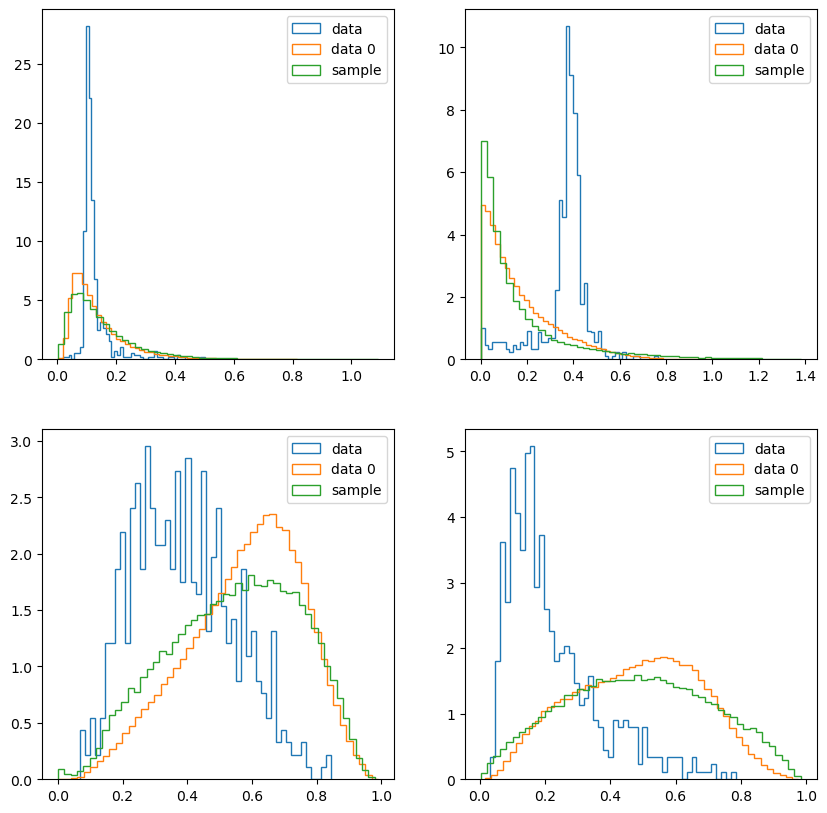

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  11 trainloss:  5.438002692106878 valloss:  5.42761813600858
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


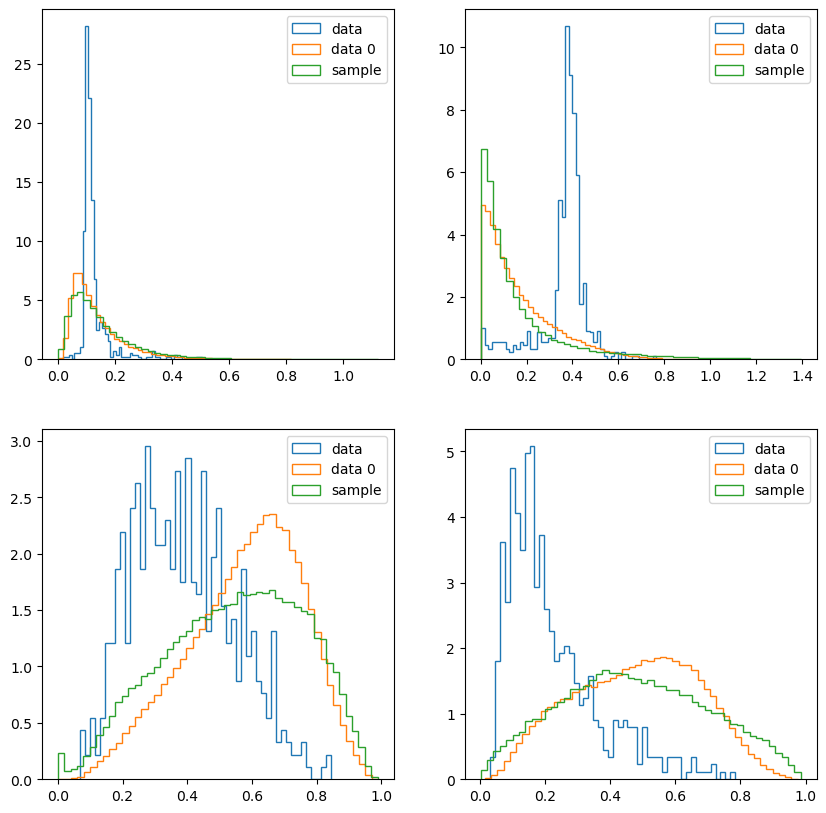

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  12 trainloss:  5.437350340966899 valloss:  5.427619795004527
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


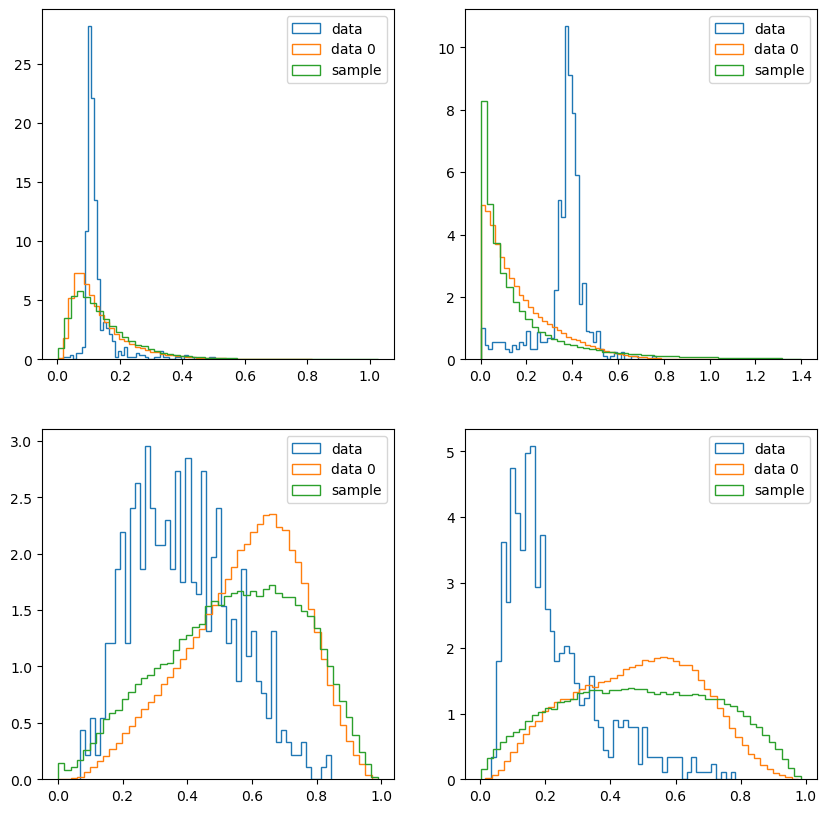

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  13 trainloss:  5.440716228724524 valloss:  5.427714924017589
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


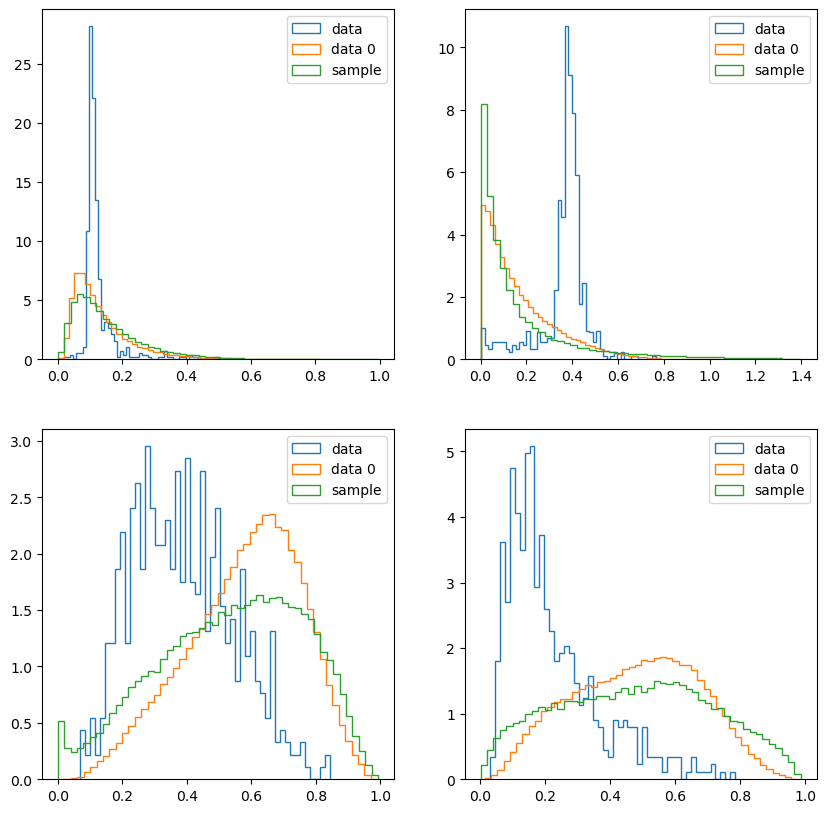

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  14 trainloss:  5.439317216434239 valloss:  5.42774314681689
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


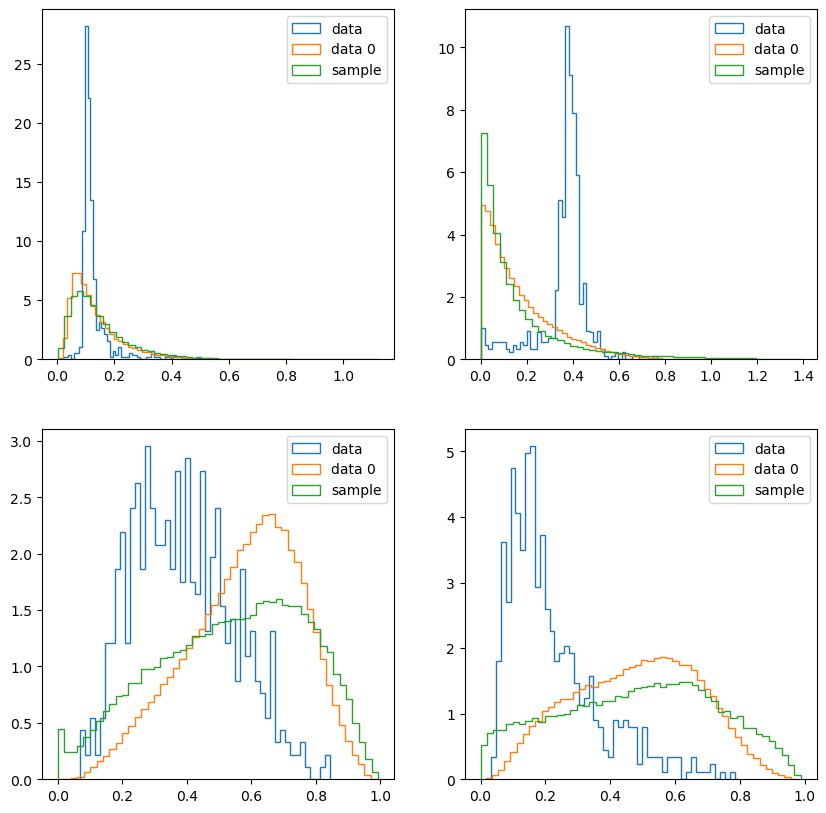

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  15 trainloss:  5.438778147039054 valloss:  5.427797824144363
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


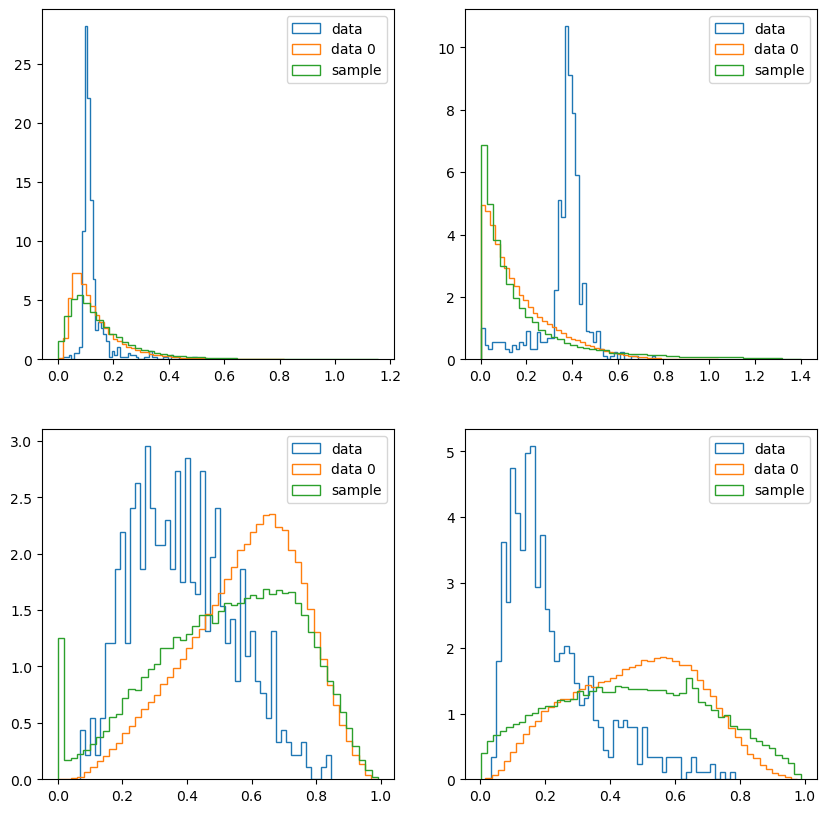

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  16 trainloss:  5.436794969327281 valloss:  5.427580992380778
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


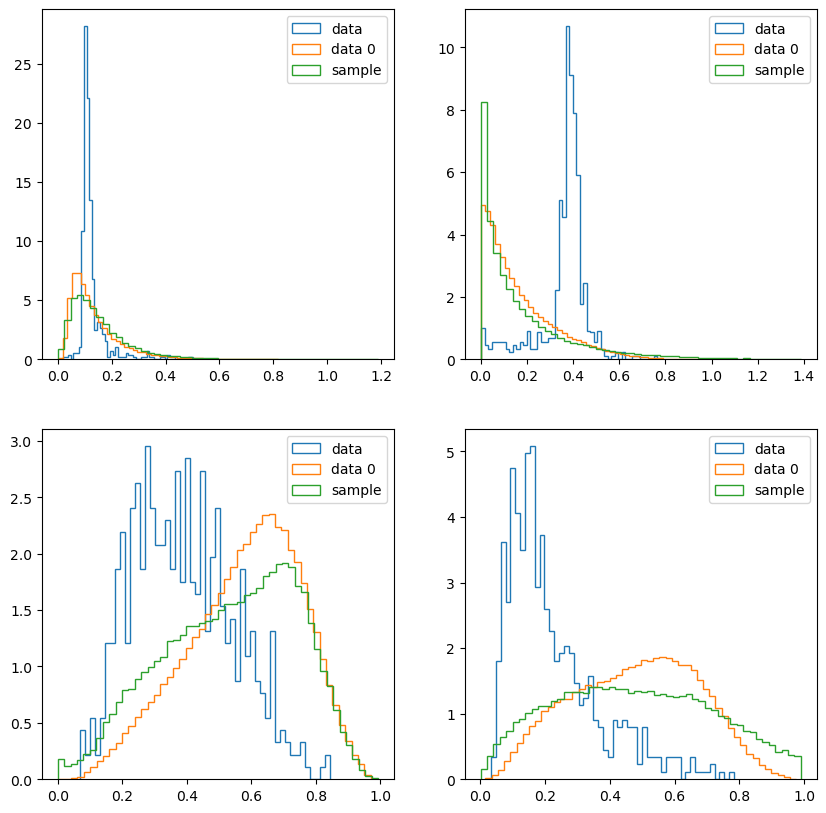

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  17 trainloss:  5.437635814794437 valloss:  5.4277390241622925
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


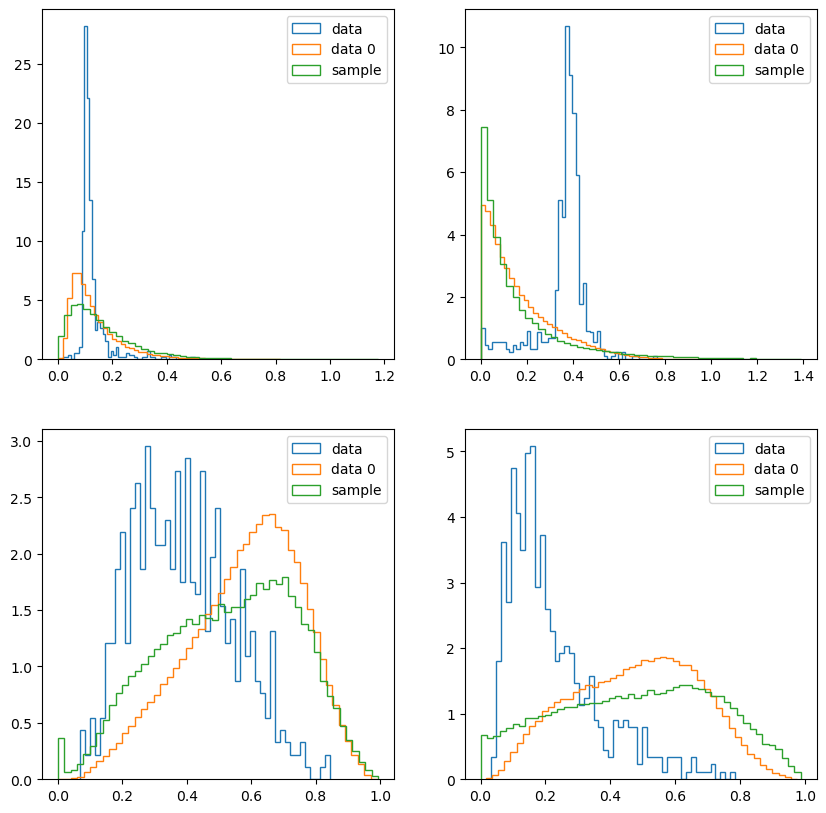

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  18 trainloss:  5.438055345702869 valloss:  5.427581995725632
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


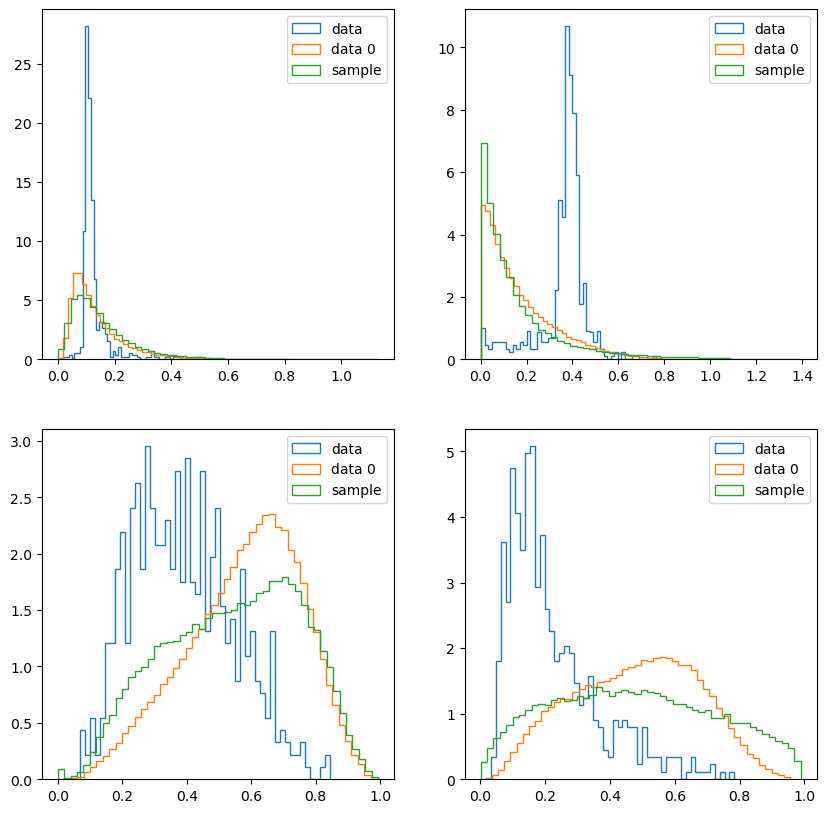

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  19 trainloss:  5.436763529996992 valloss:  5.427705546220143
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


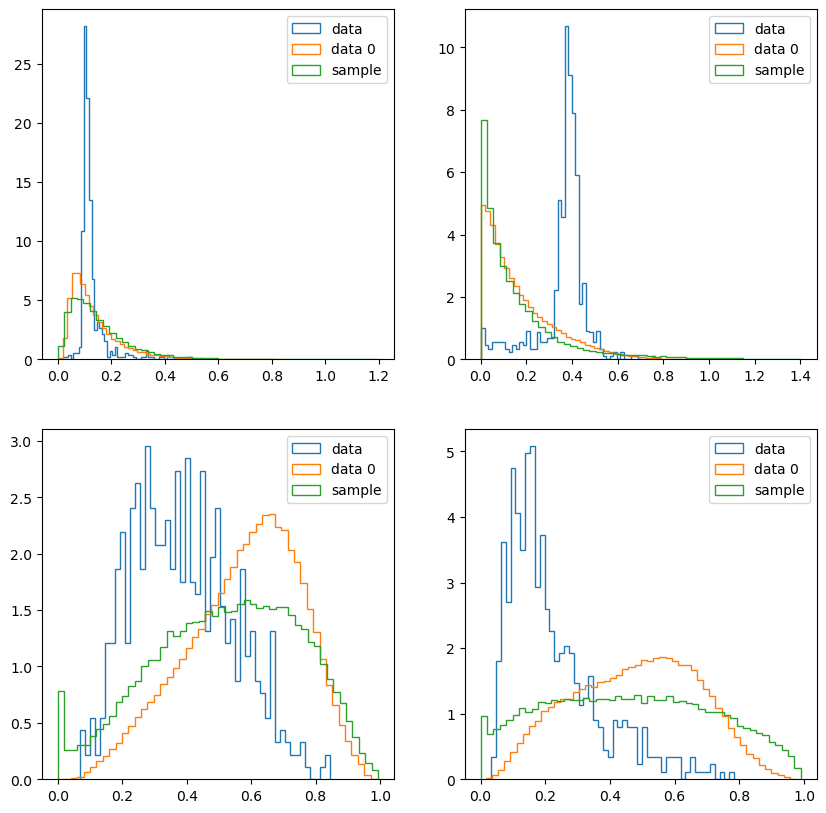

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  20 trainloss:  5.438984246433529 valloss:  5.427741199731827
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


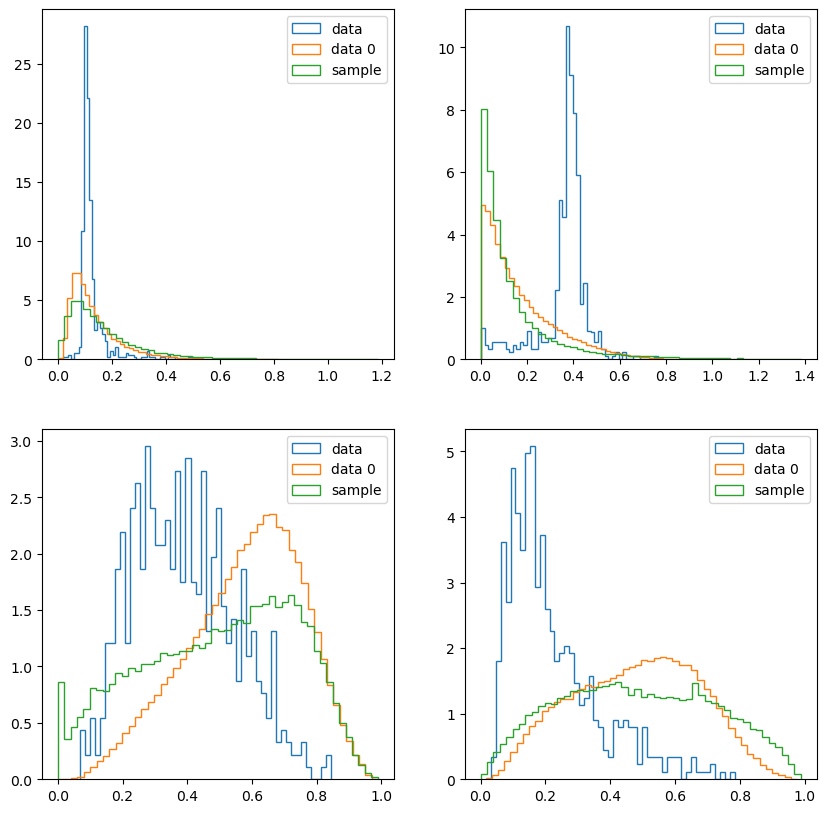

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  21 trainloss:  5.438240901196851 valloss:  5.427957107623418
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


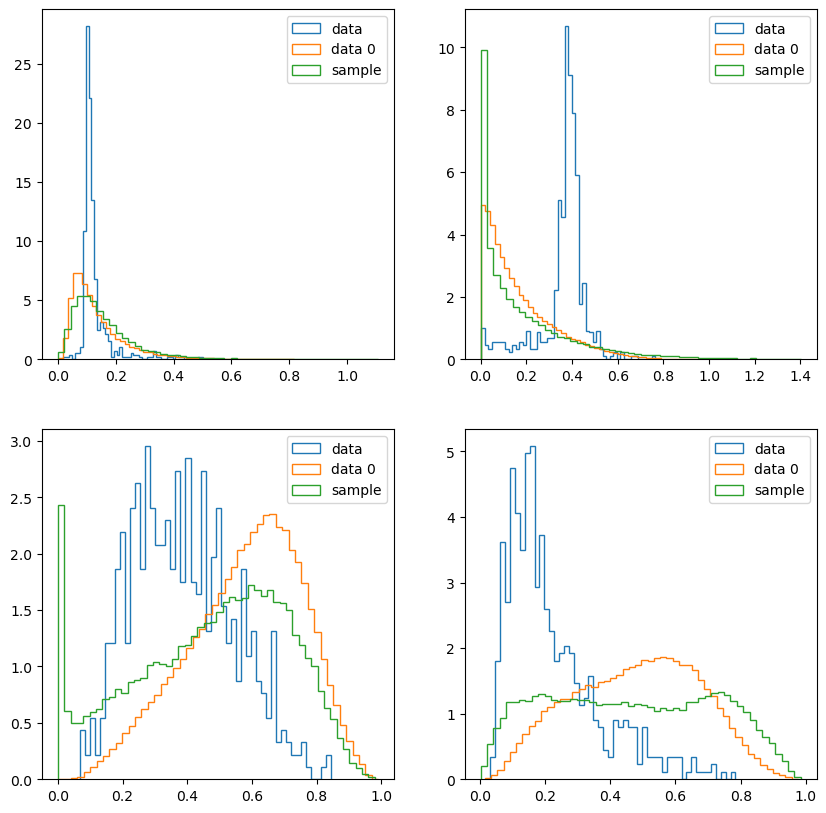

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  22 trainloss:  5.437724424705346 valloss:  5.428078403075536
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


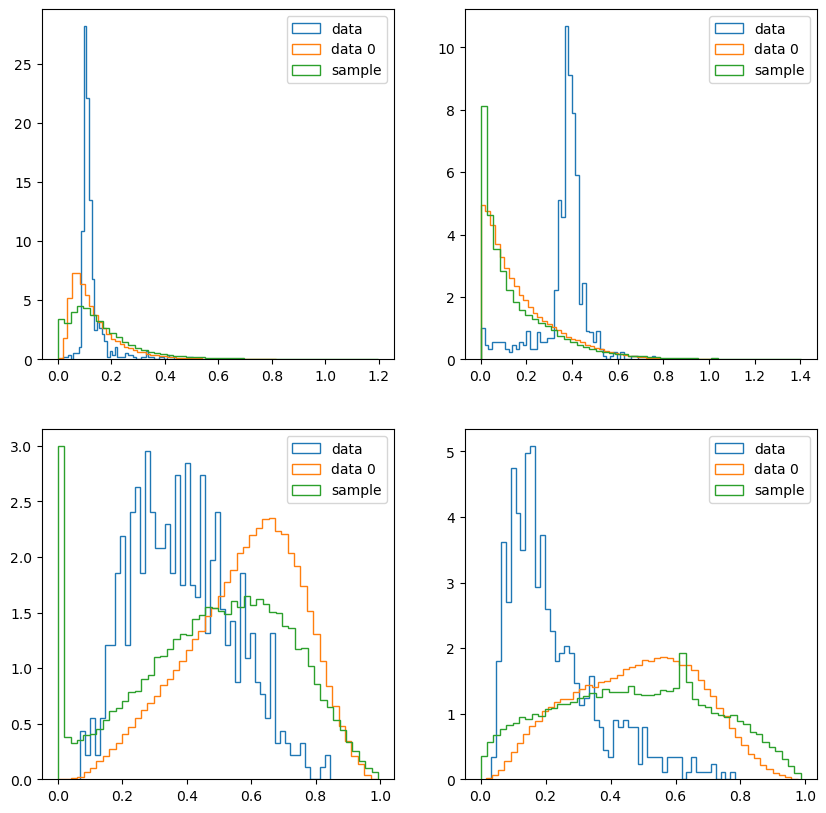

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  23 trainloss:  5.438875218315603 valloss:  5.427769015232722
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


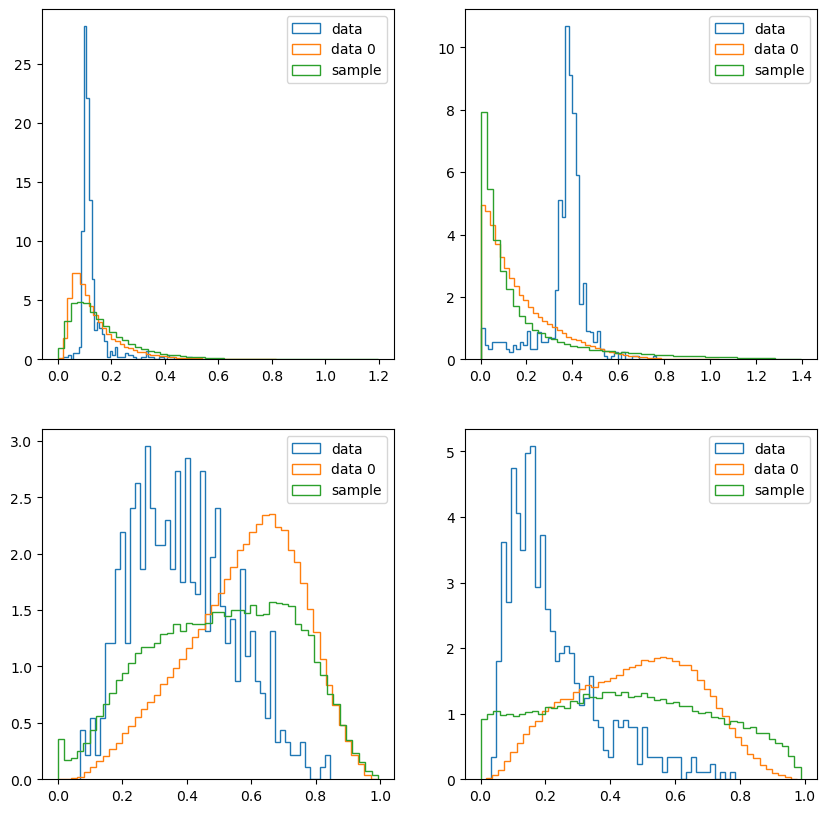

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  24 trainloss:  5.439055524610575 valloss:  5.427846451600392
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


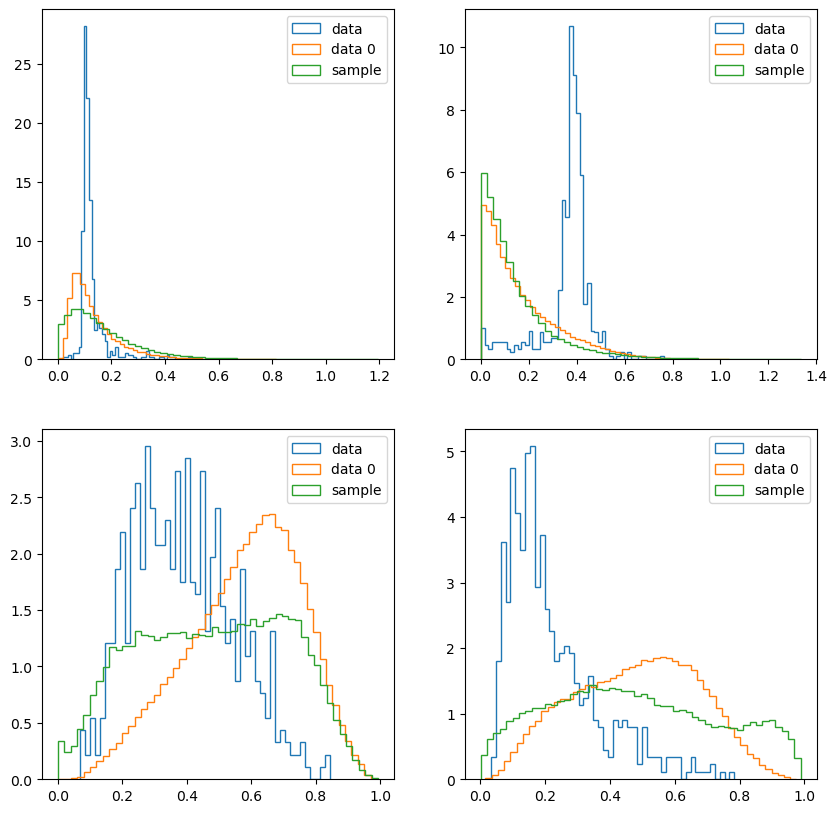

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  25 trainloss:  5.4384457895446525 valloss:  5.427610019842784
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


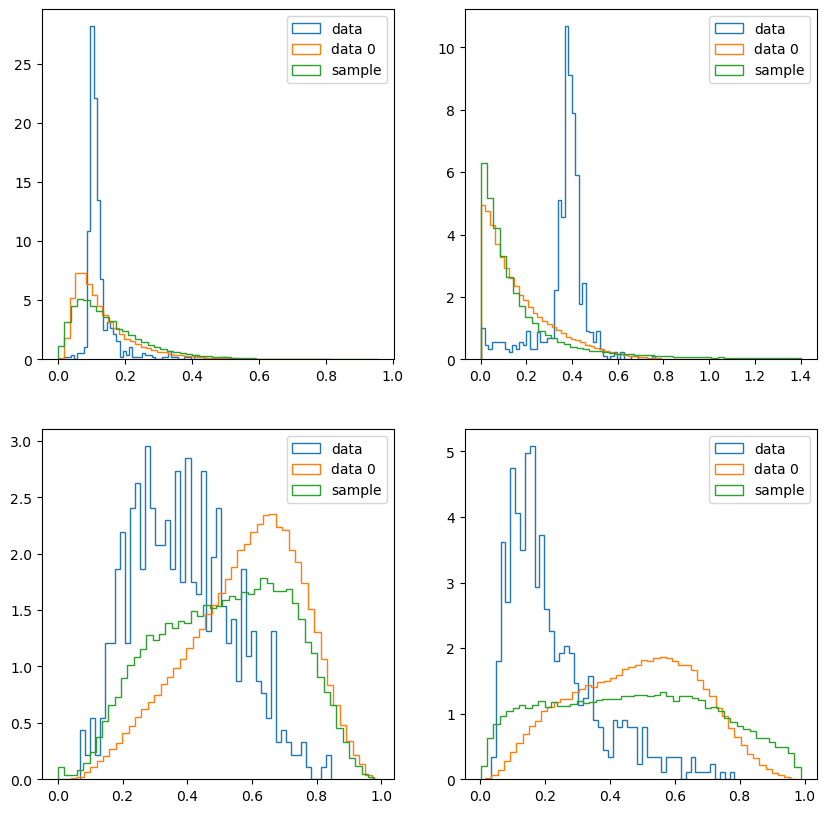

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  26 trainloss:  5.4390798672472584 valloss:  5.428163250287374
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


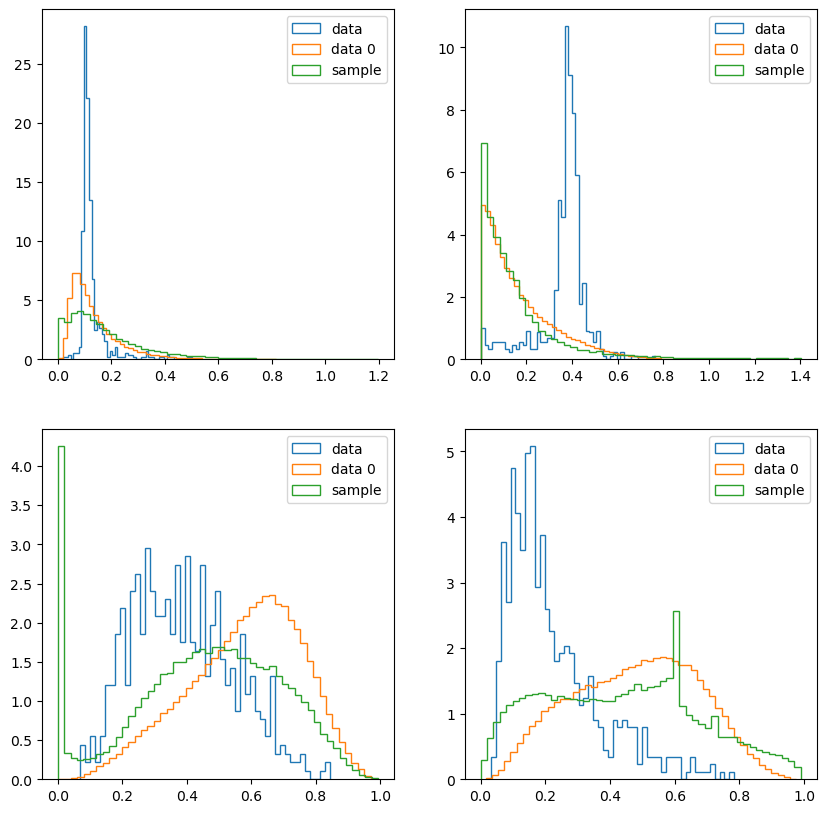

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  27 trainloss:  5.437060136675336 valloss:  5.42746979991595
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


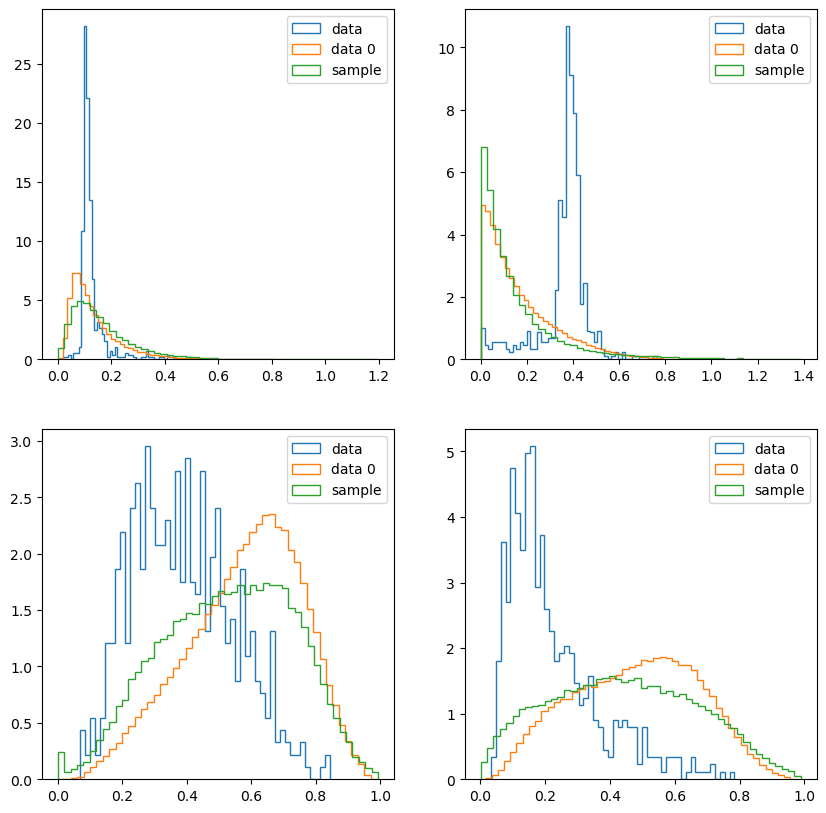

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  28 trainloss:  5.437967242556137 valloss:  5.427868018547694
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


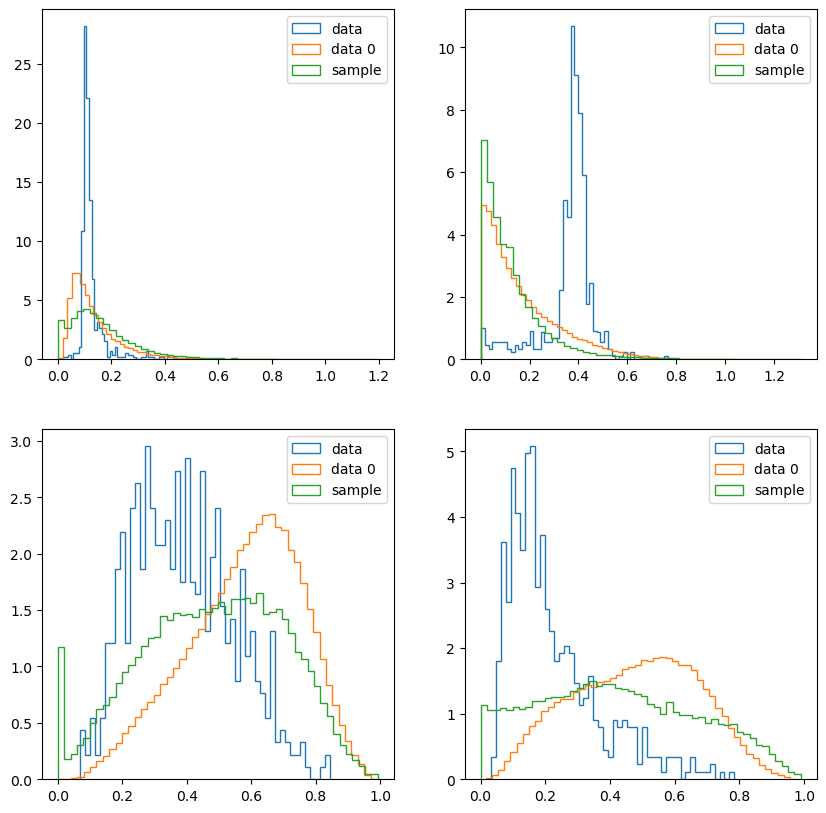

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  29 trainloss:  5.439400926294686 valloss:  5.427737424770991
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


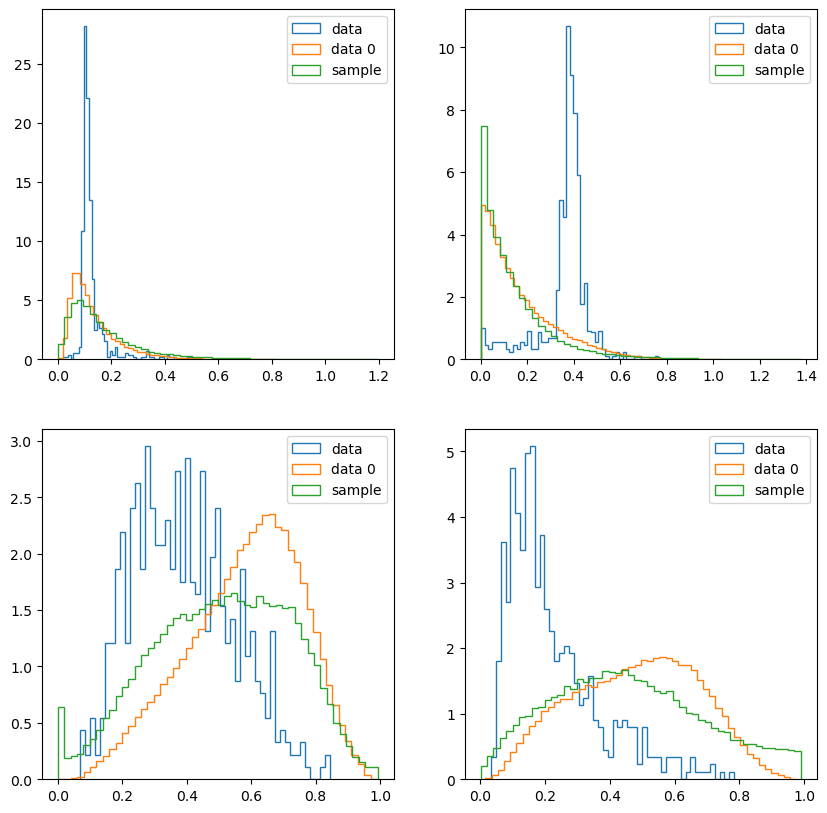

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  30 trainloss:  5.438389903830684 valloss:  5.427899261315663
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


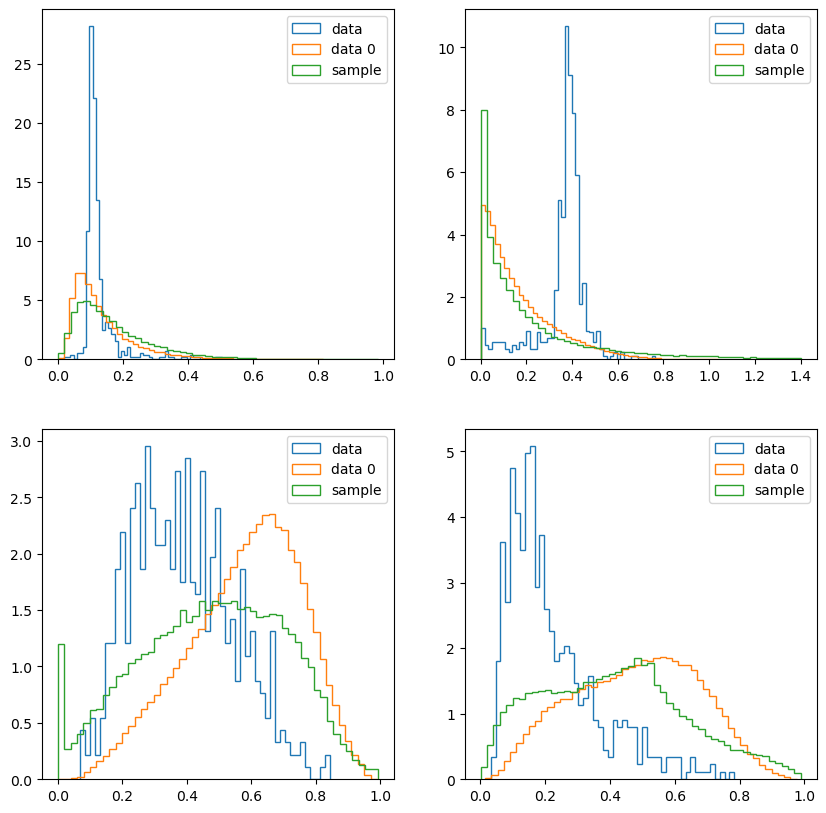

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  31 trainloss:  5.438706539664807 valloss:  5.4277864793936415
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


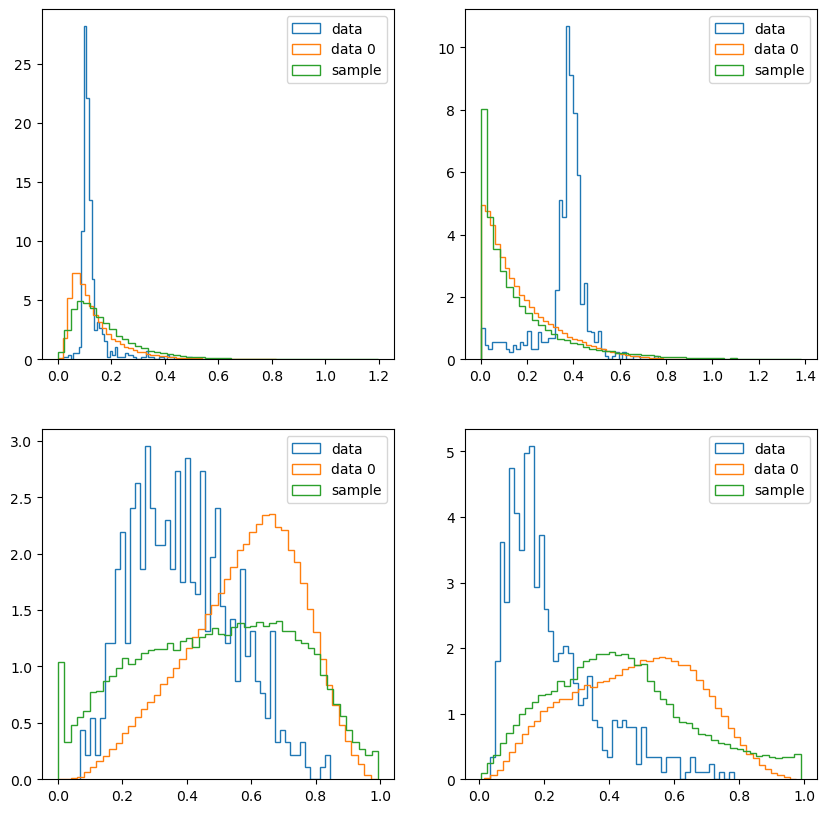

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  32 trainloss:  5.43833476030677 valloss:  5.427674442529678
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


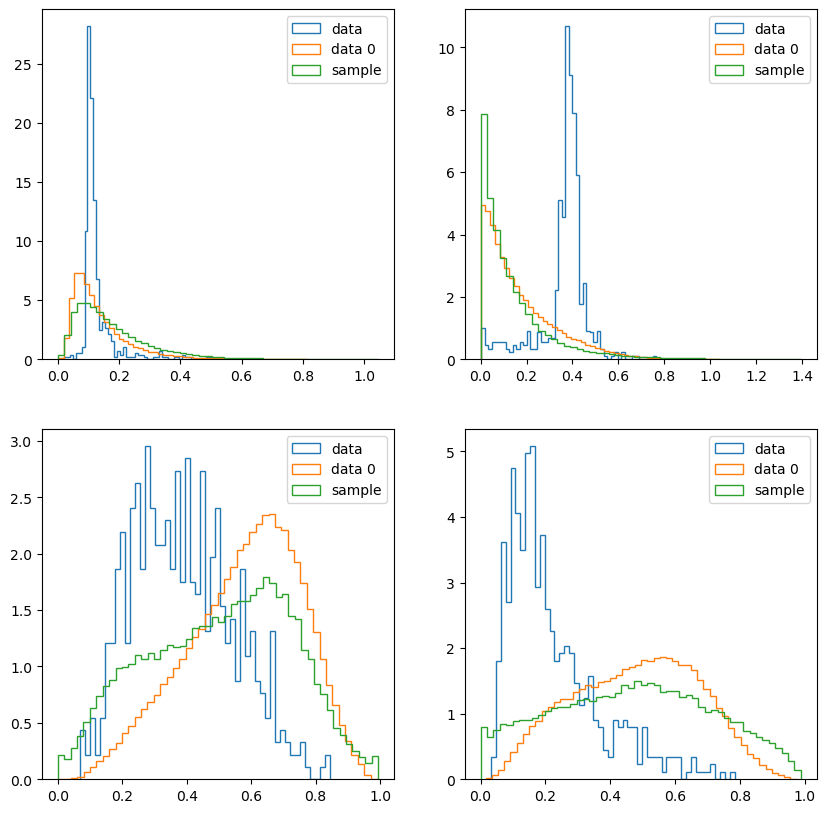

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  33 trainloss:  5.439162707229039 valloss:  5.427628844976425
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


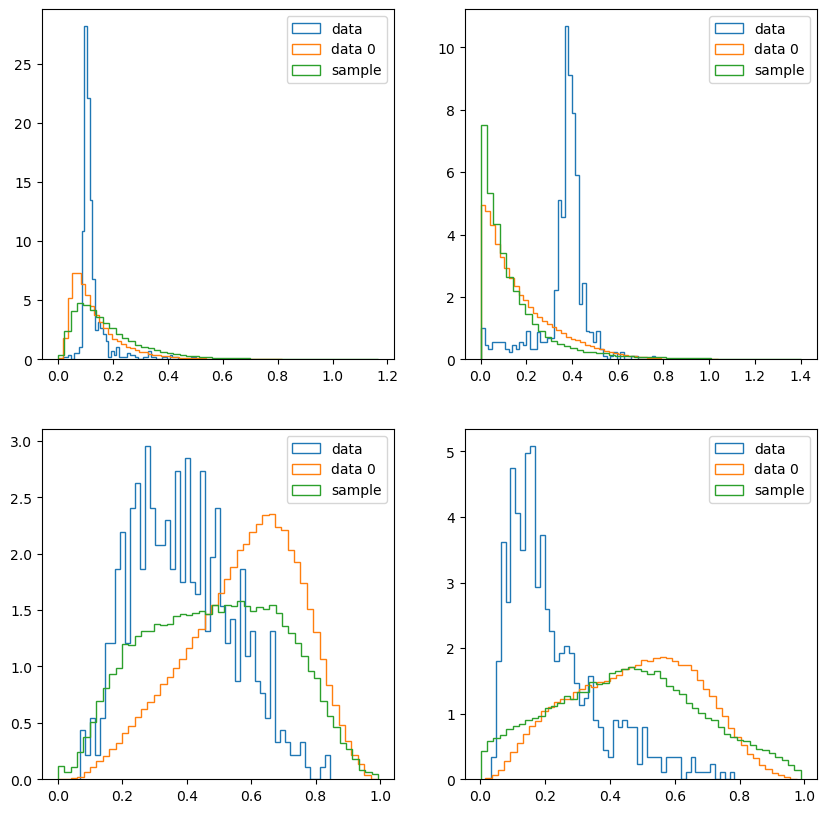

value of w: 0.004830204771159823
value of w: 0.004830204771159823
epoch:  34 trainloss:  5.4380671010356565 valloss:  5.427833437919617
x_samples shape torch.Size([60964, 5])
all_data shape (121928, 6)


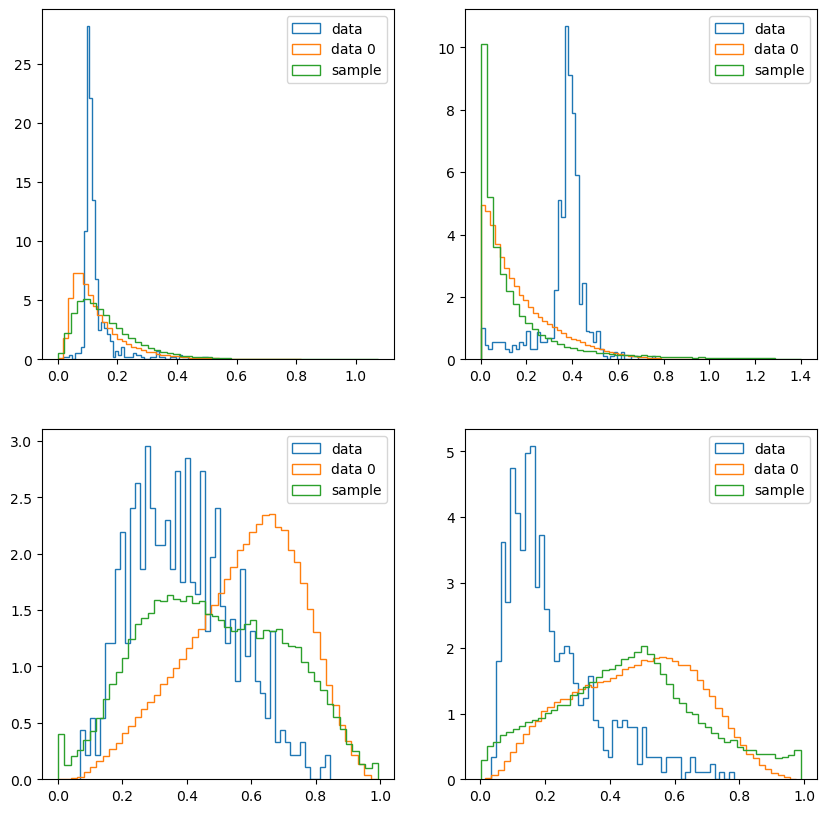

value of w: 0.004830204771159823


In [21]:
lr = []

for epoch in range(epochs):

    train_loss = r_anode(model_S,model_B.model,true_w,optimizer, scheduler, trainloader, 
                         pre_parameters, device=device, mode='train',\
                          data_loss_expr=args.data_loss_expr)
    val_loss = r_anode(model_S,model_B.model,true_w,optimizer, scheduler, valloader, 
                       pre_parameters, device=device, mode='val',\
                        data_loss_expr=args.data_loss_expr)


    ##################################
    ##############################
    # Save model and weights

    torch.save(model_S.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{epoch}.pt')

    
    if args.mode_background == 'train' or args.mode_background == 'pretrained':
        torch.save(model_B.model.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{epoch}.pt')


    if args.wandb:
            wandb.log({'train_loss': train_loss, 'val_loss': val_loss, \
                'true_w': true_w})


    if np.isnan(train_loss) or np.isnan(val_loss):
        print(' nan loss ')
       # if args.wandb:
        #    wandb.finish()
        #break

    

    print('epoch: ', epoch, 'trainloss: ', train_loss, 'valloss: ', val_loss)
    valloss.append(val_loss)
    trainloss.append(train_loss)
    lr.append(scheduler.get_last_lr()[0])

    if ~(np.isnan(train_loss) or np.isnan(val_loss)):
        
  #  x_samples_train = generate_transformed_samples(model_S.model, traintensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
  #  x_samples_val = generate_transformed_samples(model_S.model, valtensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
       # x_samples_train = generate_transformed_samples(model_S, traintensor_S[0:100], pre_parameters['CR'], device=device).cpu().detach().numpy()
       # x_samples_val = generate_transformed_samples(model_S, valtensor_S[0:100], pre_parameters['CR'], device=device).cpu().detach().numpy()
      #  x_samples = model_S.sample(10000).detach().cpu()
      #  
        x_samples = model_S.sample(1, traintensor_S[:,0].reshape(-1,1)).detach().cpu()
        x_samples = x_samples.reshape(-1,4)
        x_samples = inverse_standardize(x_samples, pre_parameters_CR["mean"], pre_parameters_CR["std"])
        x_samples = inverse_logit_transform(x_samples, pre_parameters_CR["min"], pre_parameters_CR["max"])
        x_samples = torch.hstack((traintensor_S[:,0].reshape(-1,1).detach().cpu(), x_samples))
       # x_samples = np.vstack((x_samples_train, x_samples_val))
        x_samples = x_samples[~np.isnan(x_samples).any(axis=1)]
        

        print('x_samples shape', x_samples.shape)
        print('all_data shape', all_data.shape)

        figure = plt.figure(figsize=(10,10))
        for i in range(1,5):
            plt.subplot(2,2,i)
            #if dims > 1:
            plt.hist(all_data[:,i][all_data[:,-1]==1],bins=50, density=True, label=f'data', histtype='step')
            plt.hist(all_data[:,i][all_data[:,-1]==0],bins=50, density=True, label=f'data 0', histtype='step')
            plt.hist(x_samples[:,i],bins=50, density=True, label=f'sample', histtype='step')
            plt.legend(loc='upper right')
        # plt.title(f'Nflow vs S for {i}, epoch {epoch}')
            plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/nflow_S_{i}.png')
            if args.wandb:
                wandb.log({f'nflow_S': wandb.Image(figure)})

        plt.show()



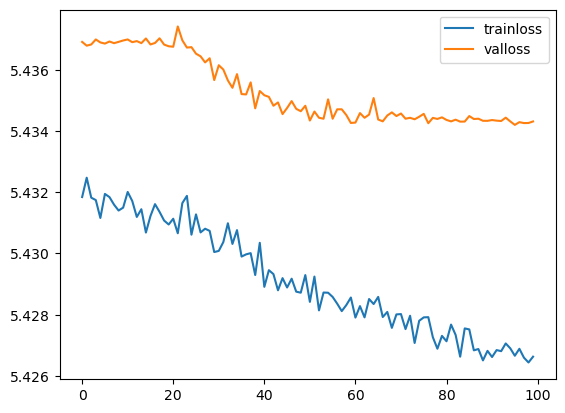

In [ ]:
plt.plot(trainloss, label='trainloss')
plt.plot(valloss, label='valloss')
plt.legend()
plt.show()

In [ ]:
np.argmin(valloss)

95

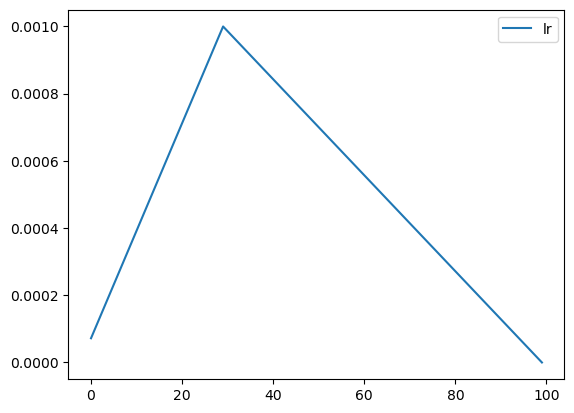

In [ ]:
plt.plot(lr, label='lr')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    print(model_S.log_prob(inputs=testtensor_S[0:100,1:-1], context=testtensor_S[0:100,0].reshape(-1,1)))

tensor([ -9.8671,  -7.2733,  -6.1445,  -7.4992,  -7.4681, -10.7178,  -5.2859,
         -8.7236, -11.6155,  -7.5341,  -6.2780,  -5.9681,  -8.5683,  -5.7911,
         -7.9050,  -4.8273,  -7.3705,  -4.6425, -10.7312,  -9.9690,  -7.3552,
         -7.9058,  -7.9117,  -4.0898,  -5.6957,  -5.8957,  -5.4564,  -7.7220,
         -6.4353,  -8.0322,  -7.6473, -10.2383,  -7.6067,  -6.2625,  -9.5454,
         -2.8682,  -6.4288, -10.5112, -10.0697,  -5.8880,  -7.6601,  -9.4786,
         -7.2926,  -7.1518,  -9.9956,  -8.1026,  -4.2826,  -4.9423,  -7.2312,
         -7.4597,  -7.7795,  -5.8636,  -9.0840,  -8.3893,  -7.6284,  -6.5189,
         -5.8218,  -5.5775,  -3.5451,  -5.3466, -11.5130,  -8.9525, -10.8511,
         -7.9299,  -6.5368, -11.5387,  -5.1943,  -6.8512,  -6.1487,  -6.8957,
         -7.0051, -13.2942,  -6.7033,  -6.2655,  -5.8910,  -5.9256,  -5.6486,
         -9.1991,  -7.4094,  -9.1442, -11.2487, -10.6701,  -9.5521,  -8.1018,
         -7.8188,  -5.6914,  -6.9212,  -3.8102,  -4.4106,  -8.32

In [ ]:
testloader = torch.utils.data.DataLoader(testtensor_S, batch_size=test_batch_size, shuffle=False)

DensityEstimator has 274800 parameters


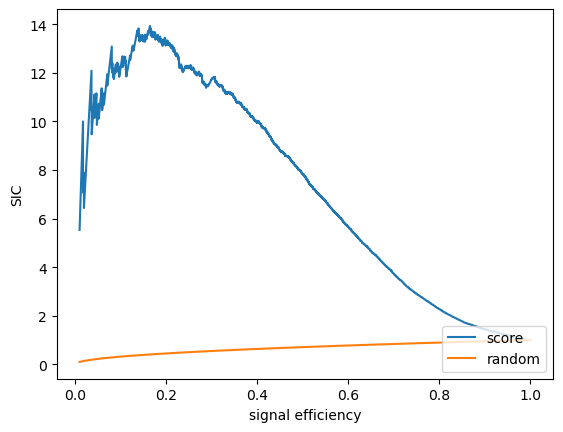

In [ ]:


#if ~np.isnan(train_loss) or ~np.isnan(val_loss):


# Load best model
if not args.ensemble:
    index = np.argmin(valloss).flatten()[0]

    model_S.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
    
    model_S.model.eval()
    log_S = evaluate_log_prob(model_S.model, testtensor_S, 
                                pre_parameters['SR'], transform = True).cpu().detach().numpy()
    #S = np.exp(log_S)


else:
    log_S = []
    sorted_index = np.argsort(valloss).flatten()[0:10]
    for index in sorted_index:

        model_S.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
        
        model_S.eval()
        log_S_ = []
        for i, data in enumerate(testloader):
                log_S_.extend(model_S.log_prob(data[:,1:-1],context=data[:,0].reshape(-1,1)).cpu().detach().numpy().tolist())
           
        #log_S_ = evaluate_log_prob(model_S.model, testtensor_S, 
                                    #pre_parameters['SR'], transform = True).cpu().detach().numpy()


        log_S.append(log_S_)

    log_S = np.array(log_S)
    S = np.exp(log_S)
    S = np.mean(S, axis=0)
    log_S = np.log(S + 1e-32)


if args.mode_background == 'train' or args.mode_background == 'pretrained':
    model_B.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{index}.pt'))

test_data = inverse_transform(testtensor_S, pre_parameters['SR']).cpu().detach().numpy()
label_test = test_data[:,-1]

model_S.eval()

train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()





# load CR model
val_losses = np.load(f'{args.CR_path}/valloss_list.npy')

if not args.ensemble:
    best_epoch = np.argsort(val_losses)[0]
else:
    best_epoch = np.argsort(val_losses)[0:10]


model_B = DensityEstimator(args.config_file, eval_mode=True, device=device)
log_B = []
for epoch in best_epoch:
#  model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{epoch}.par", device=device)
    model_B.model.load_state_dict(torch.load(f'{args.CR_path}/model_CR_{epoch}.pt'))

    model_B.model.eval()
    with torch.no_grad():
        log_p = evaluate_log_prob(model_B.model, testtensor_B, pre_parameters['CR'], transform=True).cpu().detach().numpy()
        log_B.append(log_p)

log_B = np.array(log_B)
log_B = np.mean(log_B, axis=0)

likelihood_ = log_S - log_B
likelihood = np.nan_to_num(likelihood_, nan=0, posinf=0, neginf=0)        

mask = ~ (np.isnan(likelihood) | np.isinf(likelihood))

likelihood = likelihood[mask]
label_test_masked = label_test[mask]

sic_score , tpr_score , auc_score = SIC(label_test_masked, likelihood)

figure = plt.figure()

plt.plot(tpr_score, sic_score, label='score')
plt.plot(tpr_score, tpr_score**0.5, label='random')
plt.xlabel('signal efficiency')
plt.ylabel('SIC')

plt.legend(loc='lower right')
if args.wandb:
    wandb.log({'SIC': wandb.Image(figure)})
    wandb.log({'AUC': auc_score, 'max SIC': np.max(sic_score)})

plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/SIC.png')
plt.show()


# check density estimation


np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/valloss.npy', valloss)
np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/trainloss.npy', trainloss)

if args.wandb:
    wandb.finish()
